In [56]:
# Import packages
%reload_ext autoreload
%autoreload 2

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Sersic1D
from astropy.modeling import Fittable1DModel

In [111]:
class Spergel1D(Fittable1DModel):
    from astropy.modeling import Parameter

    amplitude = Parameter(default=1, description="Surface brightness at r_eff")
    r_eff = Parameter(default=1, description="Effective (half-light) radius")
    nu = Parameter(default=0.5, description="Spergel Index")
    _kv = None
    
    _z = np.array(
            [-0.00788962, 0.0735303, -0.27770785, 0.99483285, 1.25227402]
        )
    
#     @classmethod
    def evaluate(cls, r, amplitude, r_eff, nu):
        """One dimensional Sersic profile function."""

        if cls._kv is None:
            from scipy.special import kv, gamma
            cls._kv = kv
            cls._gamma = gamma
        
        cnu = cls._z[0] * nu ** 4 + cls._z[1] * nu ** 3 + cls._z[2] * nu ** 2 + cls._z[3] * nu + cls._z[4]
        x = np.sqrt((r / r_eff)**2 + 1e-6) * cnu
        return amplitude * cnu**2 / (2 * np.pi * r_eff**2) * (x / 2) ** nu * cls._kv(nu, x) / cls._gamma(nu + 1)
    
    @property
    def input_units(self):
        if self.r_eff.unit is None:
            return None
        return {self.inputs[0]: self.r_eff.unit}

    def _parameter_units_for_data_units(self, inputs_unit, outputs_unit):
        return {'r_eff': inputs_unit[self.inputs[0]],
                'amplitude': outputs_unit[self.outputs[0]]}

In [156]:
from kuaizi.measure import bn
from scipy.special import gamma
def sersic_L0(amplitude, r_eff, n):
    b = bn(n)
    h = r_eff / b**n
    I0 = amplitude * np.e**b
    return np.pi * I0 * h**2 * gamma(2 * n + 1)

In [279]:
david_nus = []
david_res = []
david_amp = []

r_eff = 10
ns = np.linspace(0.5, 4., 50)
for n in ns:
    ser = Sersic1D(amplitude=1, r_eff=r_eff, n=n)
    x = np.linspace(0, 200, 800)
    y = ser(x)
    david = Spergel1D(amplitude=2 * sersic_L0(1, r_eff, n), 
                      r_eff=r_eff, 
                      nu=0.5 - 0.36 * (n - 1))
    david.r_eff.fixed = True
    fit_t = fitting.LevMarLSQFitter()
    david = fit_t(david, x, y)
    david_nus.append(david.nu.value)
    david_res.append(david.r_eff.value)
    david_amp.append(david.amplitude.value)
#     plt.plot(x, y)
#     plt.plot(x, david(x))
#     plt.yscale('log')
    # plt.plot(r, ser(r))
    # plt.plot(r, np.log10(ser(r)))

[ 0.04913607 -0.71617268  3.91080029 -9.75982742 10.05678307  0.56215767
 -7.91817952  2.24241979  4.0896339  -3.6047578   1.8876589 ]


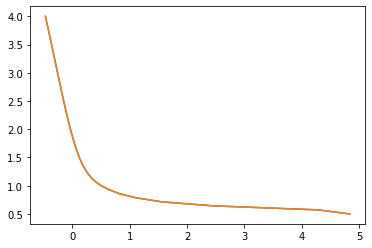

In [284]:
plt.plot(david_nus, ns)
poly = np.poly1d(np.polyfit(david_nus, ns, deg=10))
plt.plot(david_nus, poly(david_nus))
print(np.polyfit(david_nus, ns, deg=10))

In [285]:
np.polyfit(david_nus, ns, deg=10)

array([ 0.04913607, -0.71617268,  3.91080029, -9.75982742, 10.05678307,
        0.56215767, -7.91817952,  2.24241979,  4.0896339 , -3.6047578 ,
        1.8876589 ])

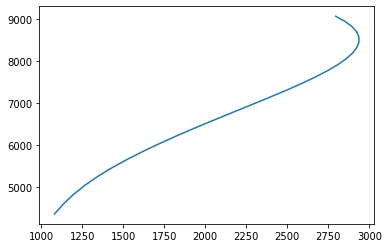

In [253]:
plt.plot(david_amp, [sersic_L0(1, 20, n) for n in np.linspace(0.8, 4., 30)])

In [239]:
n = 3
r_eff = 15

ser = Sersic1D(amplitude=1, r_eff=r_eff, n=n)
x = np.linspace(0, 200, 200)
y = ser(x)
david = Spergel1D(amplitude=sersic_L0(1, r_eff, n), r_eff=r_eff, nu=0.5 - 0.36 * (n - 1))
david.r_eff.fixed = True
fit_t = fitting.LevMarLSQFitter()
david = fit_t(david, x, y)
david

<Spergel1D(amplitude=5935.29757137, r_eff=15., nu=-0.26115553)>

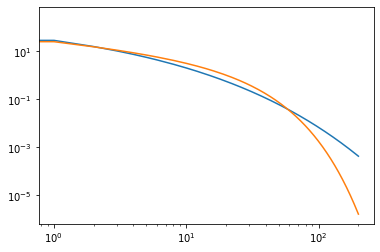

In [240]:
plt.plot(x, y)
plt.plot(x, david(x))
plt.yscale('log')
plt.xscale('log')

In [286]:
from kuaizi.measure import nu_to_n

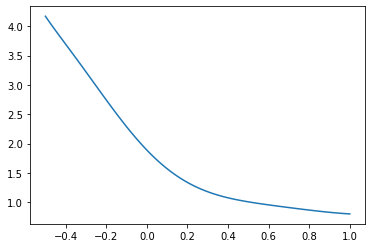

In [287]:
x = np.linspace(-0.5, 1.0, 100)
plt.plot(x, nu_to_n(x))